# Логистическая регрессия

Сегодня мы поработаем с задачей логистической регрессии на примере конкурса каггл https://www.kaggle.com/c/home-credit-default-risk/overview
    
    
В нем необходимо было


Для тех, кто хочет погрузиться глубже, очень рекомендую для начала такой ноутбук с вводной к этому конкурсу.
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

Мы  рассмотрим соревнование по машинному обучению  Home Credit bank который проводился на сайте Kaggle. Цель этого конкурса - использовать исторические данные о заявках на получение кредита, чтобы предсказать, сможет ли заявитель погасить ссуду. Это стандартная задача  **обучения с учителем - бинарная классификация**:

1) Метки калассов есть в обучающих данных и цель состоит в том, чтобы обучить модель научиться предсказывать метки на основе этих данных.
2) Бинарная классификация: метка класса представляет собой двоичную переменную, **0 (выплатит кредит вовремя)**, **1 (возникнут трудности с погашением кредита)**

В этом соревновании дается много дополнительной информации и множество датасетов довольно объемных и обширных. Чтобы сосредаточиться на методах машинного обучения, но не на обработке данных мы будем использовать только один из датасетов - в котором находится основная информация
разбирать мы все признаки не будем, 

Чтобы не терять нить, давайте как и в прошлый раз напишем **check-list** и пойдем по нему:

    1. Работа с данными
        1.1. Простейшая обработка
        1.2. Сформируем отложенную выборку
        1.3. Обработка категориальных признаков
            1.3.1. Обработка пропущенных значений
            1.3.2. Перевод в числовое значение (encoding)
        1.4. Обработка числовых признаков
            1.4.1 Обработка пропущенных значений
                1.4.1.1. У числовых фичей только с двумя значениями
                1.4.1.2. У всех остальных фичей
    2. Моделирование
        2.1. Определим метрику, на которую будем смотреть
        2.2. Построим наивный алгоритм и замерим его качество
        2.3. Построим логистическую регрессию
        2.4. Замерим ее качество
        2.5. Построим ROC-AUC
        2.6. Выберем порог и замерим precision, recall, f-score

# 1. Данные - посмотрим на них

In [1]:
%%time
import numpy as np
import pandas as pd

df = pd.read_csv('application_train.csv')

CPU times: user 1.24 s, sys: 208 ms, total: 1.45 s
Wall time: 1.46 s


Датасет довольно большой и наши методы могут долго работать, поэтому мы возьмем случайной подмножество например в размере 50 000 и будем работать с ним.

In [2]:
df = df.sample(n=50000, random_state=0).reset_index(drop=True)

In [3]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,149741,1,Cash loans,F,N,N,0,117000.0,417024.0,20191.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,363290,0,Cash loans,M,N,Y,0,450000.0,640080.0,31261.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,436006,0,Revolving loans,M,Y,Y,0,450000.0,900000.0,45000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,377703,0,Cash loans,M,Y,N,1,360000.0,1125000.0,33025.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,188624,0,Cash loans,M,Y,Y,0,675000.0,835380.0,42840.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


In [4]:
# Сразу удалим уникальный айди
df.drop(columns=['SK_ID_CURR'], inplace=True)

Видим, что у нас есть очень разнородные признаки 122 признака - среди них мы видим как числовые, так и бинарные, также видим категорилаьные, где классов больше, чем 2.

Давайте посмотрим на категориальные фичи, убедимся, что среди них нет тех, с которыми мы умеем работать и оставим только числовые и бинарные.

In [5]:
%%time
for c in df.dtypes[df.dtypes == object].keys():
    print ("---- %s ---" % c)
    print (df[c].value_counts())

---- NAME_CONTRACT_TYPE ---
NAME_CONTRACT_TYPE
Cash loans         45188
Revolving loans     4812
Name: count, dtype: int64
---- CODE_GENDER ---
CODE_GENDER
F      33029
M      16970
XNA        1
Name: count, dtype: int64
---- FLAG_OWN_CAR ---
FLAG_OWN_CAR
N    32981
Y    17019
Name: count, dtype: int64
---- FLAG_OWN_REALTY ---
FLAG_OWN_REALTY
Y    34758
N    15242
Name: count, dtype: int64
---- NAME_TYPE_SUITE ---
NAME_TYPE_SUITE
Unaccompanied      40492
Family              6490
Spouse, partner     1838
Children             523
Other_B              260
Other_A              154
Group of people       41
Name: count, dtype: int64
---- NAME_INCOME_TYPE ---
NAME_INCOME_TYPE
Working                 25905
Commercial associate    11653
Pensioner                8910
State servant            3520
Student                     6
Unemployed                  4
Maternity leave             2
Name: count, dtype: int64
---- NAME_EDUCATION_TYPE ---
NAME_EDUCATION_TYPE
Secondary / secondary special    3539

Мы видим некоторые интересные колонки например 
'NAME_CONTRACT_TYPE'
'CODE_GENDER'
'FLAG_OWN_CAR'
'FLAG_OWN_REALTY'
'EMERGENCYSTATE_MODE'

Мы видим, что это все на самом деле бинарные признаки, но либо есть пропуски либо имеют текстовые названия.



## 1.1. Перейдем к простейшей обработке, которая нам дальше очень поможет

Также мы видим, что в признаке пол - есть пропущенные значения необычного вида - XNA, дачайте заменим их на обычные пропуски.

In [6]:
df.replace('XNA', np.nan, inplace=True)

In [7]:
#это все колонки, которые имеют количественные значения или числовые (например бинарные 0,1)
numeric_features = df.dtypes[(df.dtypes == np.float64) | (df.dtypes == np.int64)].keys().tolist()
#также выберем заинетерсовавшие нас категориальные признаки 
cat_features = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']

Ограничимся набором таких колонок, остальные пока отложим.

In [8]:
df = df[numeric_features + cat_features]

Отлично теперь можно переходить к обработке пропущенных значений.

## 1.2. Сформируем отложенную выборку

In [9]:
#Отложим часть выборки, чтобы убедиться в дальнейшем, что наша модель не переобучилась.
df_test = df.sample(n=10000, random_state=0)
df_train = df.drop(index=df_test.index)

df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

Теперь мы можем начать заполнять пропущенные значения и обрабатывать признаки.

## 1.3. Обработка категориальных признаков

### 1.3.1. Обработка пропущенных значений

Начнем с обработки пропущенных значений, как мы помним есть несколько вариантов, мы выберем **заполнение средним** и **заполнение самым частым значением**

В sklearn сть отдельный класс, который очень помогает в таких ситуациях.

Ссылка на его документацию: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [10]:
from sklearn.impute import SimpleImputer

In [11]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять самым частым значением
imp_cat = SimpleImputer(strategy="most_frequent")

In [12]:
%%time
df_train[cat_features] = imp_cat.fit_transform(df_train[cat_features])
df_test[cat_features] = imp_cat.transform(df_test[cat_features])

CPU times: user 29.8 ms, sys: 4.46 ms, total: 34.3 ms
Wall time: 35.3 ms


In [13]:
df_train[cat_features].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,Cash loans,F,N,N,No
1,Revolving loans,M,Y,Y,No
2,Cash loans,M,Y,Y,No
3,Cash loans,M,Y,Y,No
4,Cash loans,F,N,Y,No


<!-- ### 1.3.1. Перевод в числовое значение (encoding) -->

Теперь нам нужно перевести их в числовой тип. То есть одному типу присвоить значение 1 - другому 0.

###  1.3.2. Перевод в числовое значение (encoding)

Переведем их в бинарный вид для этого в sklearn есть специальный класс

Ссылка на его документацию: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html

In [14]:
from sklearn.preprocessing import OrdinalEncoder

In [15]:
# Создадим класс категориального обработчика
enc = OrdinalEncoder()

In [16]:
# Всем категориальным значениям присвоим либо 1 либо 0, в зависимости от того, какое значение они принимают.
df_train[cat_features] = enc.fit_transform(df_train[cat_features])
df_test[cat_features] = enc.transform(df_test[cat_features])

In [17]:
df_train[cat_features].head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,EMERGENCYSTATE_MODE
0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0
2,0.0,1.0,1.0,1.0,0.0
3,0.0,1.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0


Отлично категориальные фичи мы обработали, теперь перейдем к числовым.

## 1.4. Обработка числовых признаков

### 1.4.1 Обработка пропущенных значений

#### 1.4.1.1. У числовых фичей только с двумя значениями

В числовых фичах можно заметить, что есть такие признаки как флаги  - они по другому являются бинарными, то есть принимают значение либо 0 либо 1. Значит при обработке их пропущенных значений нужно будет использовать стратегию заполнения самым частым значением. Для всех остальных признаков бедум использовать заполнение средним значением. Повторим то что делали для категориальных признаков здесь.

In [18]:
df[numeric_features].head()

,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,0,117000.0,417024.0,20191.5,360000.0,0.020246,-21774,-2125,-4611.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
1,0,0,450000.0,640080.0,31261.5,450000.0,0.046220,-18499,-2055,-3052.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
2,0,0,450000.0,900000.0,45000.0,900000.0,0.010643,-18084,-4159,-8525.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,0.0
3,0,1,360000.0,1125000.0,33025.5,1125000.0,0.018634,-12319,-2532,-12304.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,0,0,675000.0,835380.0,42840.0,675000.0,0.020713,-10151,-2516,-2789.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0


Для начала найдем все такие признаки, которые принимают только два значения и запомним их, чтобы обработать отдельно.

In [19]:
cat_bin_features = []
for i in numeric_features:
    if len(df[i].value_counts().keys().tolist()) == 2:
        cat_bin_features.append(i)

Давайте посмотрим на них.

In [20]:
cat_bin_features

['TARGET',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

Мы уже так обрабатывали другие категориальные признаки, поэтому здесь просто повторим.

In [21]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять самым частым значением
imp_bin_cat = SimpleImputer(strategy="most_frequent")

In [22]:
%%time
df_train[cat_bin_features] = imp_cat.fit_transform(df_train[cat_bin_features])
df_test[cat_bin_features] = imp_cat.transform(df_test[cat_bin_features])

CPU times: user 36.7 ms, sys: 9.79 ms, total: 46.5 ms
Wall time: 47.1 ms


#### 1.4.1.2. У всех остальных числовых фичей

In [23]:
# Создадим класс обработчика пропущенных значений
# Будем заполнять медианным
imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean')

In [24]:
%%time
df_train[numeric_features] = imp_cat.fit_transform(df_train[numeric_features])
df_test[numeric_features] = imp_cat.transform(df_test[numeric_features])

CPU times: user 174 ms, sys: 43.6 ms, total: 217 ms
Wall time: 216 ms


Отлично, мы обработали данные.
Заполнили все пропуски. Перевели категориальные фичи в удобный для нас вид. Собрали итоговый обучающий датасет и итоговый тестовый датасет.

Теперь разделить пространство объектов от пространсва ответов в обучающей и тестовой выборках

In [29]:
#здесь можно посмотреть какие колоки будут у первых 10 признаков

X_train = df_train[df_train.columns[1:][:10]]
X_test = df_test[df_train.columns[1:][:10]]
y_train = df_train['TARGET']
y_test = df_test['TARGET']

In [31]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

standard = StandardScaler()
standard.fit(X_train)
X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

In [34]:
from sklearn.model_selection import train_test_split     
from sklearn.linear_model import LogisticRegression     
 
logreg = LogisticRegression()
logreg.fit(X_train_standard, y_train)

LogisticRegression()

In [37]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report


In [52]:
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_standard)[:,1])
roc_auc

0.7257353250847423

In [40]:
X_train = df_train.drop(columns='TARGET')
X_test = df_test.drop(columns='TARGET')

y_train = df_train['TARGET']
y_test = df_test['TARGET']

## 1.5. Скалирование данных

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Используем стандартное преобразование данных как в прошлом уроке.

In [41]:
from sklearn.preprocessing import StandardScaler

$$x_i^j = \frac{x_i^j - \mu_j}{\sigma_j}$$

In [42]:
# зададим объекты - трансформеры, 
# которые преобразуют наши данные и запомнят средние

standard = StandardScaler()

# метод фит вычисляет все вспомогательные значения по каждому признаку
standard.fit(X_train)

#нам нужно преобразовать как тестовую, так и тренировочную выборку,
#хорошим тоном считается вычислять вспомогательные значения по обучающей выборке
X_train_standard = standard.transform(X_train)
X_test_standard = standard.transform(X_test)

Теперь можно переходить к части моделирования.

# 2. Моделирование

## 2.1 Посмотрим на метрику

Организаторы конкурса как основную мерику выбрали ROC-AUC, но мы уже с ней знакомы, поэтому мы знаем как она строится и знаем, что схитрить также как с accuracy  с ней не получится, потому что она не чувствительна к дисбалансу классов.

Для ее подсчета в sklearn есть нужная функция.

Ссылка на ее документацию: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [43]:
from sklearn.metrics import roc_auc_score

## 2.2 Построим наивный алгоритм и посмотрим какое качество он дает

In [44]:
roc_auc_score(y_train, [0]*len(y_train))

0.5

In [45]:
roc_auc_score(y_train, [1]*len(y_train))

0.5

Мы видим, что не удалось обмануть ROC-AUC  - он правильно понял, что наша модель плохая. Качество 0.5 говорит о том, что наша модель не лучше чем "подбрасывать монетку".

## 2.3 Построим логистическую регрессию

Логистическая регрессия уже реализована в sklearn

Ссылка на ее документацию: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
#Нужно ответить на вопрос - посмотрев докуметацию
#Какая регуляризация используется здесь в дефолтных параметрах
#L1, L2 или никакой
logreg = LogisticRegression(max_iter=1000)

In [48]:
#Обучим логистическую регрессию
logreg.fit(X_train_standard, y_train)

LogisticRegression(max_iter=1000)

## 2.4 Замерим качество

In [49]:
#Чтобы вернуть предсказание вероятностей принадлежности, 
#нужно использовать метод predict_proba он возвращает 
#в первой колонке вероятность принадлежности к классу 0, а во второй к классу 1.
proba = logreg.predict_proba(X_test_standard)

In [50]:
roc_auc = roc_auc_score(y_test, proba[:,1])

In [51]:
roc_auc

0.7257353250847423

## 2.5 Построим ROC

Класс! Мы так улучшили нашу модель, но еще есть куда расти.
Давайте также нарисуем ROC кривую. Функция для нее также есть в пакете sklearn.

Ссылка на ее документацию: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test_standard)[:,1])

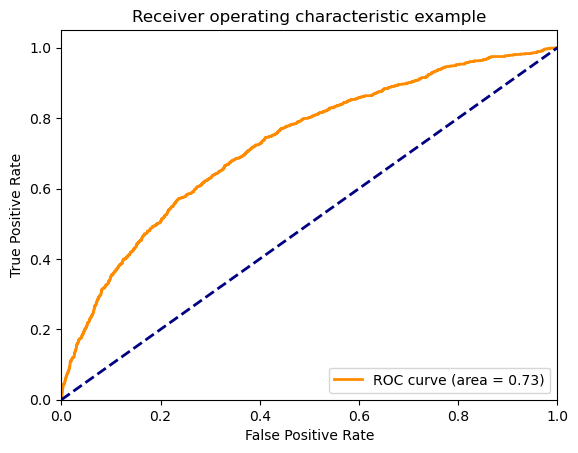

In [55]:
import matplotlib.pyplot as plt

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# 2.6. Выберем порог и замерим precision, recall, f-score

Ссылка на их документации:


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html#sklearn.metrics.recall_score \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score \
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html#sklearn.metrics.precision_score

In [56]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [57]:
print(f" Полнота при предсказании 1: {recall_score(y_test, [1]*len(y_test))} \n \
Точность при предсказании 1: {precision_score(y_test, [1]*len(y_test))} \n \
F-мера при предсказании 1: {f1_score(y_test, [1]*len(y_test))}")

 Полнота при предсказании 1: 1.0 
 Точность при предсказании 1: 0.0837 
 F-мера при предсказании 1: 0.15447079450032297


In [58]:
print(f" Полнота при предсказании 0: {recall_score(y_test, [0]*len(y_test))} \n \
Точность при предсказании 0: {precision_score(y_test, [0]*len(y_test))} \n \
F-мера при предсказании 0: {f1_score(y_test, [0]*len(y_test))}")

 Полнота при предсказании 0: 0.0 
 Точность при предсказании 0: 0.0 
 F-мера при предсказании 0: 0.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [59]:
predictions = proba[:, 1].copy()
predictions[np.where(predictions > 0.1)] = 1
predictions[np.where(predictions <= 0.1)] = 0

In [60]:
print(f" Полнота при предсказании с порогом 0.1: {recall_score(y_test, predictions)} \n \
Точность при предсказании с порогом 0.1: {precision_score(y_test, predictions)} \n \
F-мера при предсказании с порогом 0.1: {f1_score(y_test, predictions)}")

 Полнота при предсказании с порогом 0.1: 0.5412186379928315 
 Точность при предсказании с порогом 0.1: 0.18437118437118438 
 F-мера при предсказании с порогом 0.1: 0.2750455373406193
